<a href="https://colab.research.google.com/github/amogh7joshi/farmland-anomalies/blob/master/TSNE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TSNE Embedding Visualization

This script conducts feature extraction and t-SNE on the Agriculture-Vision dataset images, to try and visualize them in a 3-dimensional embedding space.

In [2]:
import os
import re
import sys
import time
import json
import shutil

import cv2
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

from sklearn.manifold import TSNE

from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Model, load_model

## Load Data

The first step consists of actually loading in and inflating the complete Agriculture-Vision dataset. To do this, we will first connect to Google Drive.

In [3]:
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Access Drive.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

Then, import the zip file containing the dataset into Colab.

In [4]:
download = drive.CreateFile({'id': '1JxFr8jip7jAJi9NIcXPGdRqzguoGUQ8E'})
download.GetContentFile('Agriculture-Vision.tar.gz')

Finally, we will unzip the file contents.

In [5]:
%%capture
!tar -xvf Agriculture-Vision.tar.gz

## Inspect

The next step is to get the paths for each of the different images into a single list, to be used for the following steps.

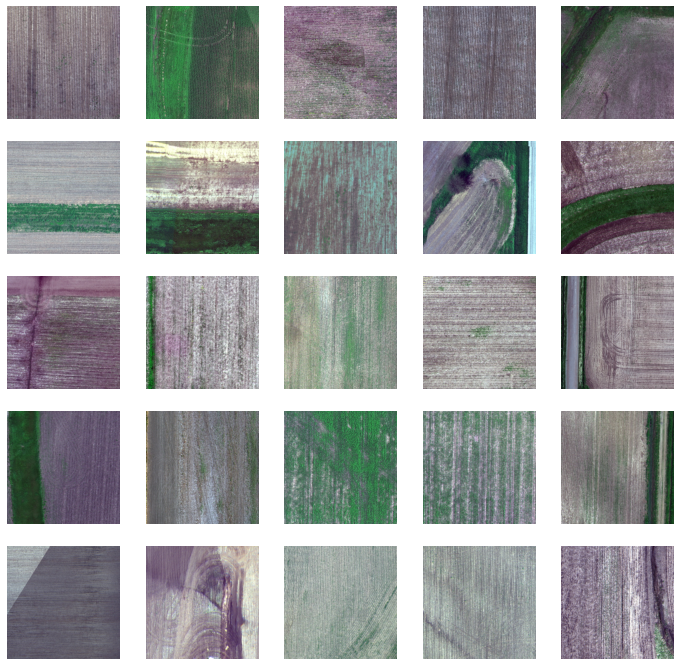

In [6]:
# Get a list of all of the RGB images from both training/validation.
train_image_path = '/content/Agriculture-Vision/train/images/rgb'
train_rgb_images = [os.path.join(train_image_path, path) for path in os.listdir(train_image_path)]
val_image_path = '/content/Agriculture-Vision/val/images/rgb'
val_rgb_images = [os.path.join(val_image_path, path) for path in os.listdir(val_image_path)]
rgb_images = train_rgb_images + val_rgb_images

# Load in a few random images and display them.
random_images = np.random.choice(rgb_images, size = 25, replace = False)
# Create the figure.
fig, axes = plt.subplots(5, 5, figsize = (12, 12))
for indx, ax in enumerate(axes.flat):
  # Read in and convert the image color.
  image = cv2.imread(random_images[indx])
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  # Display the image without the axis.
  ax.imshow(image)
  ax.axis('off')

## Feature Extraction

Now, we will extract image features from the input RGB dataset images, converting them from $512\times512\times3$ images into $1000$-dimensional feature vectors.

In [9]:
# Construct the feature extraction model.
feature_extractor_base = VGG19(include_top = False, weights = 'imagenet', input_shape = (512, 512, 3))
x = GlobalAveragePooling2D()(feature_extractor_base.output)
feature_extractor = Model(feature_extractor_base.input, x)

# Display the model summary.
feature_extractor.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 512, 512, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 512, 512, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 512, 512, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 256, 256, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 256, 256, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 256, 256, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 128, 128, 128)     0   

Conduct the actual feature extraction.

In [8]:
# Create an array to hold all of the extracted image feature vectors.
feature_vectors = np.zeros(shape = (len(rgb_images), feature_extractor.output_shape[-1]))

# Iterate over all of the images.
for indx, image_path in enumerate(tqdm(rgb_images)):
  # Load in the image and perform color conversion.
  image = cv2.imread(image_path)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  # Add a batch dimension to the image.
  image = np.expand_dims(image, axis = 0)
  # Extract the image features.
  features = feature_extractor.predict(image)
  # Add feature vectors to the array.
  feature_vectors[indx] = features

## Extract TSNE Embeddings

Now, we need to perform t-distributed stochastic neighbor embedding on the actual feature vectors to properly visualize them in a 2-dimensional space.

In [10]:
tsne = TSNE(n_components = 2, perplexity = 100, learning_rate = 150.0, n_iter = 1000, verbose = 2)
embeddings = tsne.fit_transform(feature_vectors)

[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 17332 samples in 1.753s...
[t-SNE] Computed neighbors for 17332 samples in 315.592s...
[t-SNE] Computed conditional probabilities for sample 1000 / 17332
[t-SNE] Computed conditional probabilities for sample 2000 / 17332
[t-SNE] Computed conditional probabilities for sample 3000 / 17332
[t-SNE] Computed conditional probabilities for sample 4000 / 17332
[t-SNE] Computed conditional probabilities for sample 5000 / 17332
[t-SNE] Computed conditional probabilities for sample 6000 / 17332
[t-SNE] Computed conditional probabilities for sample 7000 / 17332
[t-SNE] Computed conditional probabilities for sample 8000 / 17332
[t-SNE] Computed conditional probabilities for sample 9000 / 17332
[t-SNE] Computed conditional probabilities for sample 10000 / 17332
[t-SNE] Computed conditional probabilities for sample 11000 / 17332
[t-SNE] Computed conditional probabilities for sample 12000 / 17332
[t-SNE] Computed conditional probabilities for 

## Generate Visualization

Now, we will finally develop the visualization of the actual TSNE embeddings.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


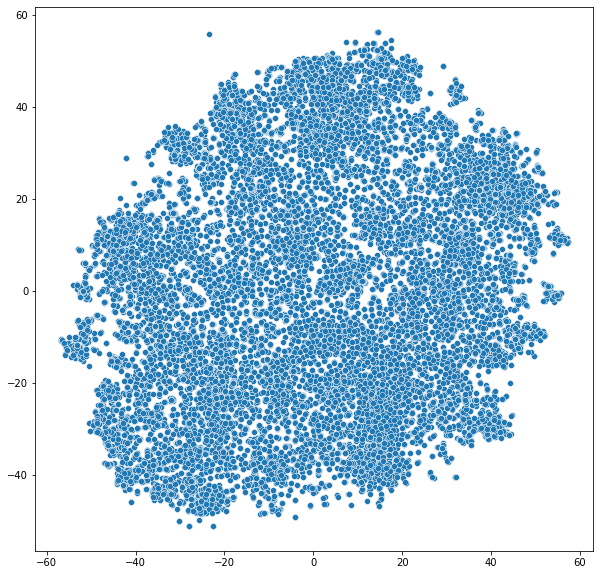

In [11]:
plt.figure(figsize = (10, 10))
sns.scatterplot(embeddings[:, 0], embeddings[:, 1])

### Labeled Visualization

In order to try and get an idea of the locations of the actual anomalies, we will plot those as well. To do this, we will first load in the JSON files containing the classes associated with each image.

In [12]:
# First, construct the fallback JSON generation methods.
def get_classes(dataset_dir):
   """Get classes for the Agriculture-Vision dataset."""
   label_dir = os.path.join(dataset_dir, 'train', 'labels')
   return [item for item in os.listdir(label_dir) if item != '.DS_Store']

def get_paths(mode, dataset_dir):
   """Get list of image and directory paths for usage in main generation method."""
   if mode not in ['train', 'val', 'test']:
      raise ValueError("Invalid mode for file and path acquisition: should be train, val, or test.")

   # Create and validate paths to each individual directory.
   image_dir = os.path.join(dataset_dir, mode, 'images')
   assert os.path.exists(image_dir), "Path to dataset feature 'images' missing."
   boundary_dir = os.path.join(dataset_dir, mode, 'boundaries')
   assert os.path.exists(boundary_dir), "Path to dataset feature 'boundaries' missing."
   mask_dir = os.path.join(dataset_dir, mode, 'masks')
   assert os.path.exists(mask_dir), "Path to dataset feature 'masks' missing."
   if mode != 'test':
      label_dir = os.path.join(dataset_dir, mode, 'labels')
      assert os.path.exists(label_dir), "Path to dataset feature 'labels' missing."

   # Create list of filenames for all images.
   rgb_image_dir = os.path.join(image_dir, 'rgb')
   assert os.path.exists(rgb_image_dir), "Path to dataset image feature 'rgb' missing."
   image_files = [name[:-4] for name in os.listdir(rgb_image_dir)]

   # Return filenames and directory paths.
   if mode != 'test':
      return image_dir, boundary_dir, mask_dir, label_dir, image_files
   else:
      return image_dir, boundary_dir, mask_dir, image_files

def generate(mode, output_dir, dataset_dir, generate_class_labels = False):
   """Generate json files containing image path information for use in processing."""
   generation_modes = [] # List containing modes for generation, will be iterated over.
   if mode == 'all':
      generation_modes.extend(['train', 'val', 'test'])
   elif mode == 'train':
      generation_modes.extend('train')
   elif mode == 'val':
      generation_modes.extend('val')
   elif mode == 'test':
      generation_modes.extend('test')
   else:
      raise ValueError("Invalid mode for generation: should be train, val, test, or all.")

   # Iterate over modes and generate json files for each.
   for mode in generation_modes:
      with open(os.path.join(output_dir, f'{mode}.json'), 'w') as file:
         print(f"Generating files for mode {mode}.")
         json_dump = []

         # Get directory paths and images.
         if mode == 'test':
            image_dir, boundary_dir, mask_dir, image_files = get_paths(mode, dataset_dir)
         else:
            image_dir, boundary_dir, mask_dir, label_dir, image_files = get_paths(mode, dataset_dir)

         # Generate actual json files.
         for image_file in tqdm(image_files):
            try:
               image_dict = {
                  'id': image_file,
                  'rgb': os.path.join(image_dir, 'rgb', f'{image_file}.jpg'),
                  'nir': os.path.join(image_dir, 'nir', f'{image_file}.jpg'),
                  'boundary': os.path.join(boundary_dir, f'{image_file}.png'),
                  'mask': os.path.join(mask_dir, f'{image_file}.png')
               }

               # Add label images if mode is train or val, determine image classes from arrays.
               if mode != 'test':
                  if generate_class_labels:
                     data_classes = get_classes(dataset_dir)
                     for data_class in data_classes:
                        image_dict[f'label_{data_class}'] = os.path.join(label_dir, data_class, f'{image_file}.png')

                     # Determine which images demonstrate valid features, add to json.
                     labels, classes = [], []
                     for path_name, class_path in image_dict.items():
                        if 'label' in path_name:
                           class_name = path_name[6:]
                           label_image = cv2.imread(os.path.join(dataset_dir, class_path)) / 255
                           if label_image.any():
                              classes.append(class_name)
                           labels.append(label_image)
                     if ~np.sum(labels, axis = 0).astype(bool).any():
                        classes.append('background')

                     image_dict['classes'] = classes
               # Append image dictionary to complete list of json dumps.
               json_dump.append(image_dict)

            except Exception as e:
               raise e
            finally:
               del image_dict

         # Clean and dump to json file.
         pretty_json_dump = json.dumps(json_dump, indent = 4)
         file.write(pretty_json_dump)
         

# Create the folder for the dataset, if it doesn't exist.
if os.path.exists('/content/Dataset'):
  shutil.rmtree('/content/Dataset')
if not os.path.exists('/content/Dataset'):
  os.makedirs('/content/Dataset')

# Determine if the files exist in google drive first.
try: # train.json
  download = drive.CreateFile({'id': '1Cnx4l849muhTkc7KwruZGUceTPcXIUWA'}) 
  download.GetContentFile('train.json')
except Exception as e:
  print("File train.json not found in drive.")
try: # val.json
  download = drive.CreateFile({'id': '1eHZlci4Oi2LEmRAsd116clDquMSblHp0'})
  download.GetContentFile('val.json')
except Exception as e:
  print("File val.json not found in drive.")
try: 
  download = drive.CreateFile({'id': '1757bSfoy4yUMpv6K0mH0UTYSSy6dUgBS'})
  download.GetContentFile('test.json')
except Exception as e:
  print("File train.json not found in drive.")

# Determine if files exist, and move them if necessary.
all_exist = True
for mode in ['train', 'val', 'test']:
  if os.path.exists(f'/content/{mode}.json'):
    try:
      shutil.move(f'/content/{mode}.json', f'/content/Dataset/{mode}.json')
    except Exception as e:
      raise e
  elif os.path.exists(f'/content/{mode}.json'):
    print(f"File {mode}.json already exists.")
  else:
    all_exist = False

# If all files don't exist, remake directory and generate json files.
if not all_exist:
  shutil.rmtree('/content/Dataset')
  os.makedirs('/content/Dataset')
  time.sleep(0.5)
  generate('all', '/content/Dataset', '/content/Agriculture-Vision', generate_class_labels = True)

Then, load the JSON files and pick the most prevalent class for each of the different images. 

***Note***: Some of the images may have multiple classes but since that is a small portion, we will assume that those images are negligible and simply chose the most prevalent class.

In [13]:
# Load the train/validation JSON files into lists of dictionaries, and merge them.
with open('/content/Dataset/train.json', 'r') as file:
  train_json = json.load(file)
with open('/content/Dataset/val.json', 'r') as file:
  val_json = json.load(file)
full_json = train_json + val_json

# Since the list of RGB image paths we have already loaded is in the same order 
# as the complete list of dictionaries, we can iterate over those to get the classes.
classes = []
for metadata in full_json:
  # Get the classes and add them to the full list.
  classes.append(metadata['classes'][0])

# Encode each of the different unique classes as numbers.
CLASS_TO_NUM = {k: v for v, k in enumerate(np.unique(classes))}

# Get the list of classes as numbers.
num_classes = []
for item in classes:
  num_classes.append(CLASS_TO_NUM[item])

Finally, generate the complete labeled visualization.

(-62.58127708435059, 63.02152366638184, -56.414039039611815, 61.75773181915283)

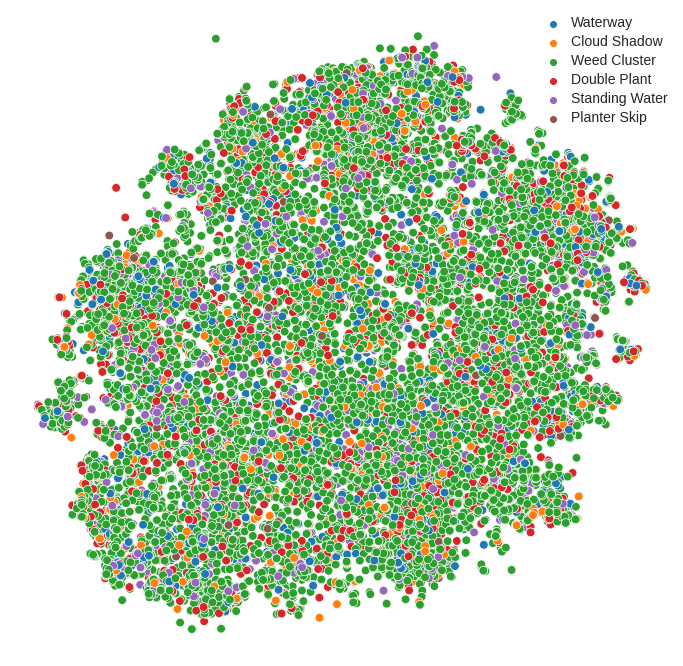

In [15]:
# Change the plot style.
from matplotlib import style
style.use('seaborn-dark')

# Define a helper method for better-looking visualizations.
def get_nice_colors(clusters):
  """Returns better-looking colors from a list of cluster classes."""
  colors = []
  if not isinstance(clusters, (list, tuple, np.ndarray)):
    return sns.color_palette()[clusters]
  for item in clusters:
    colors.append(sns.color_palette()[item])
  return colors

# Define a helper method to format the legend.
def format_legend(items):
  """Returns a list of formatted legend items."""
  formatted = []
  for item in items:
    f_item = " ".join(item.split('_'))
    f_item = f_item.title()
    formatted.append(f_item)
  return formatted

# Construct the final visualization.
plt.figure(figsize = (12, 12))
sns.scatterplot(x = embeddings[:, 0], y = embeddings[:, 1], s = 75, hue = format_legend(classes), legend = 'full')
plt.setp(plt.gca().get_legend().get_texts(), fontsize='14') 
plt.axis('off')

## Output Feature Extraction

Now, we will perform a similar feature extraction, using the actual farmland anomaly model as opposed to a base feature extractor.

In [26]:
# Load the model.
farmland_extractor_base = load_model('/content/Model-Dice-SCL-Dice-60.hdf5', custom_objects = {'dice_loss_2d': 0})

# Perform global average pooling on the top layer.
x = GlobalAveragePooling2D()(farmland_extractor_base.output)

# Construct the final farmland extractor.
farmland_extractor = Model(farmland_extractor_base.input, x)
farmland_extractor.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_19 (InputLayer)           [(None, 512, 512, 4) 0                                            
__________________________________________________________________________________________________
conv2d_324 (Conv2D)             (None, 256, 256, 128 4736        input_19[0][0]                   
__________________________________________________________________________________________________
separable_conv2d_144 (Separable (None, 256, 256, 128 676         input_19[0][0]                   
__________________________________________________________________________________________________
batch_normalization_360 (BatchN (None, 256, 256, 128 512         conv2d_324[0][0]                 
____________________________________________________________________________________________

Next, get the actual output feature vectors.

In [27]:
# Create an array to hold all of the extracted image feature vectors.
final_feature_vectors = np.zeros(shape = (len(rgb_images), farmland_extractor.output_shape[-1]))

# Create the input images, e.g. concatenated NIR/RGB images (for compatibility).
nir_images = [re.sub('rgb', 'nir', path) for path in rgb_images]

# Iterate over all of the images.
for indx, (nir_path, rgb_path) in enumerate(tqdm(zip(nir_images, rgb_images))):
  # Load in the images and perform color conversion.
  rgb_image = cv2.imread(rgb_path)
  rgb_image = cv2.cvtColor(rgb_image, cv2.COLOR_BGR2RGB)
  nir_image = cv2.imread(nir_path)
  nir_image = cv2.cvtColor(nir_image, cv2.COLOR_BGR2GRAY)
  # Concatenate the two together.
  image = np.zeros(shape = (512, 512, 4))
  image[:, :, :3] = rgb_image
  image[:, :, 3] = nir_image
  # Add a batch dimension to the image.
  image = np.expand_dims(image, axis = 0)
  # Extract the image features.
  features = farmland_extractor.predict(image)
  # Add feature vectors to the array.
  final_feature_vectors[indx] = features

## Output TSNE Embeddings

Get the t-SNE embeddings on the output feature vectors next.

In [28]:
final_tsne = TSNE(n_components = 2, perplexity = 50, learning_rate = 150.0, n_iter = 5000, verbose = 2)
final_embeddings = tsne.fit_transform(final_feature_vectors)

[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 17332 samples in 0.020s...
[t-SNE] Computed neighbors for 17332 samples in 1.865s...
[t-SNE] Computed conditional probabilities for sample 1000 / 17332
[t-SNE] Computed conditional probabilities for sample 2000 / 17332
[t-SNE] Computed conditional probabilities for sample 3000 / 17332
[t-SNE] Computed conditional probabilities for sample 4000 / 17332
[t-SNE] Computed conditional probabilities for sample 5000 / 17332
[t-SNE] Computed conditional probabilities for sample 6000 / 17332
[t-SNE] Computed conditional probabilities for sample 7000 / 17332
[t-SNE] Computed conditional probabilities for sample 8000 / 17332
[t-SNE] Computed conditional probabilities for sample 9000 / 17332
[t-SNE] Computed conditional probabilities for sample 10000 / 17332
[t-SNE] Computed conditional probabilities for sample 11000 / 17332
[t-SNE] Computed conditional probabilities for sample 12000 / 17332
[t-SNE] Computed conditional probabilities for sa

Finally, create the actual visualization.

[None, None, None, None, None, None, None, None, None, None, None, None]

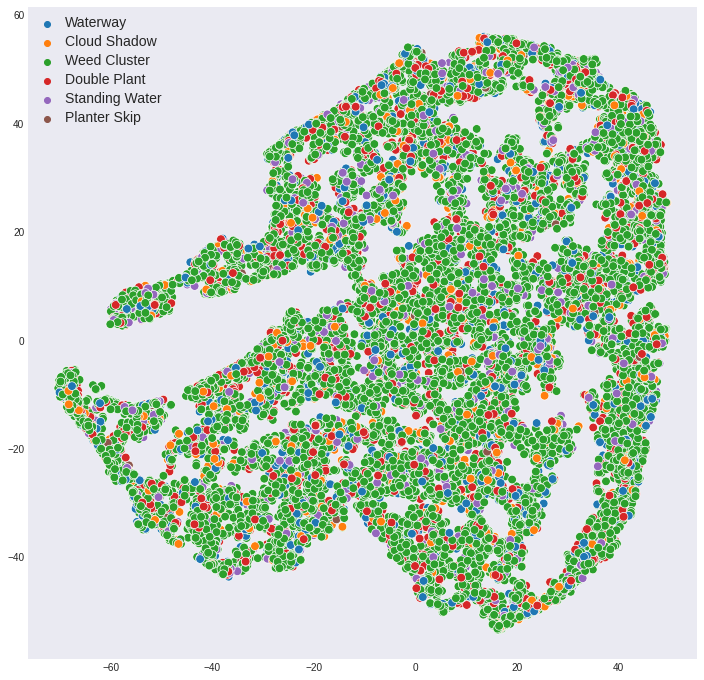

In [30]:
# Change the plot style.
from matplotlib import style
style.use('seaborn-dark')

# Define a helper method for better-looking visualizations.
def get_nice_colors(clusters):
  """Returns better-looking colors from a list of cluster classes."""
  colors = []
  if not isinstance(clusters, (list, tuple, np.ndarray)):
    return sns.color_palette()[clusters]
  for item in clusters:
    colors.append(sns.color_palette()[item])
  return colors

# Define a helper method to format the legend.
def format_legend(items):
  """Returns a list of formatted legend items."""
  formatted = []
  for item in items:
    f_item = " ".join(item.split('_'))
    f_item = f_item.title()
    formatted.append(f_item)
  return formatted

# Construct the final visualization.
plt.figure(figsize = (12, 12))
sns.scatterplot(x = final_embeddings[:, 0], y = final_embeddings[:, 1], s = 75, hue = format_legend(classes), legend = 'full')
plt.setp(plt.gca().get_legend().get_texts(), fontsize='14') 